In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile

In [ ]:


df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_763,emb_764,emb_765,emb_766,emb_767,Target_1day,Target_1week,Target_1month,Target_1year,Ticker
0,2021-06-01,75.393341,75.630189,74.351213,75.383865,10485300,0.0,0.0,23368.861,5.9,...,NaN,NaN,NaN,NaN,NaN,0.663162,4.774864,-1.392677,-6.483879,ORCL
1,2021-06-02,75.507015,76.672309,75.327016,76.047028,12249300,0.0,0.0,23368.861,5.9,...,NaN,NaN,NaN,NaN,NaN,0.776863,4.026428,-2.302147,-6.070183,ORCL
2,2021-06-03,75.601763,77.174428,75.459653,76.823891,12038700,0.0,0.0,23368.861,5.9,...,NaN,NaN,NaN,NaN,NaN,1.705299,1.146362,-1.468452,-7.673927,ORCL
3,2021-06-04,77.136525,79.542898,77.089160,78.529190,14502900,0.0,0.0,23368.861,5.9,...,NaN,NaN,NaN,NaN,NaN,0.994774,0.009506,-1.013695,-9.686905,ORCL
4,2021-06-07,78.576573,79.817653,78.491304,79.523964,10445600,0.0,0.0,23368.861,5.9,...,NaN,NaN,NaN,NaN,NaN,0.634766,-1.250549,-0.814743,-9.200996,ORCL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8098,2025-01-31,690.385772,704.673049,684.970607,688.567383,19331700,0.0,0.0,29723.864,4.0,...,0.863545,-0.508524,-0.082002,-0.069431,0.599713,NaN,NaN,NaN,NaN,META
8099,2025-01-31,418.141600,419.848170,414.079737,414.229431,34223400,0.0,0.0,29723.864,4.0,...,0.744444,-0.874127,-0.850657,-0.140685,0.215989,NaN,NaN,NaN,NaN,MSFT
8100,2025-01-31,123.768618,127.838243,119.179044,120.058960,390372900,0.0,0.0,29723.864,4.0,...,0.961006,-0.782348,-0.184249,-0.365351,0.674120,NaN,NaN,NaN,NaN,NVDA
8101,2025-01-31,170.410004,173.000000,169.130005,170.059998,8722500,0.0,0.0,29723.864,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ORCL


In [ ]:
#Read Data
# df = pd.read_csv('/Users/wonminkim/Projects/DATCapstone/data2/data.csv', index_col=0)
cwd = os.getcwd()

with zipfile.ZipFile(f'{cwd}/data/_data.csv.zip') as z:
    with z.open('data.csv') as f:
        df = pd.read_csv(f, index_col=0)

df['Date'] = pd.to_datetime(df['Date'])

#Forward fill -> micro, macro, stock / fill na -> sentiment
df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)

df = df.dropna(subset=df.columns[0:-5])

# Sorting
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# Lag feature (Exclude embedding columns)
lag_cols = df.columns[1:44]
lags = [1, 3, 5, 7, 14, 30]
lag_features = []

for col in lag_cols:
    for lag in lags:
        lagged = df.groupby('Ticker')[col].shift(lag)
        lag_features.append(lagged.rename(f'{col}_lag{lag}'))

lag_df = pd.concat(lag_features, axis=1)

df = pd.concat([df.reset_index(drop=True), lag_df.reset_index(drop=True)], axis=1)

In [ ]:
import glob

# Read articles df
csv_files = glob.glob(os.path.join("data", "*articles*.csv"))

df_articles_list = []

for file in csv_files:
    # get ticker from filename
    ticker = os.path.basename(file).split('_')[0]
    df_articles = pd.read_csv(file)
    df_articles['Ticker'] = ticker
    df_articles_list.append(df_articles)

# concat articles dataframe
df_articles = pd.concat(df_articles_list, ignore_index=True)

# Articles dataframe preprocessing
df_articles["Date"] = pd.to_datetime(df_articles["time"], errors='coerce', utc=True).dt.tz_convert(None).dt.date
df_articles = df_articles[['Date', 'Ticker', 'sentiment']]
sentiment_dummies = pd.get_dummies(df_articles['sentiment'])
df_encoded = pd.concat([df_articles[['Date', 'Ticker']], sentiment_dummies], axis=1)
df_articles = df_encoded.groupby(['Date', 'Ticker']).sum().reset_index()
df_articles['Date'] = pd.to_datetime(df_articles['Date'])

df_articles['articles_avg_sentiment'] = (df_articles['Negative'] * -1 + df_articles['Neutral'] * 0 + df_articles['Positive']) / (df_articles['Negative'] + df_articles['Neutral'] + df_articles['Positive'])
df_articles.columns = ['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral', 'Articles_positive', 'Articles_avg_sentiment']
df_articles

df = pd.merge(df, df_articles, on=['Date', 'Ticker'], how = 'left')

# Fill 0 except the target columns
df[[col for col in df.columns if 'Target' not in col]] = df[[col for col in df.columns if 'Target' not in col]].fillna(0)

In [ ]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=0.95, random_state=42)
emb_cols = [col for col in df.columns if col.startswith("emb_")]
X_emb = df[emb_cols]
X_emb_pca = pca.fit_transform(X_emb)

# PCA columns
pca_columns = [f"emb_pca_{i}" for i in range(X_emb_pca.shape[1])]
df_pca_part = pd.DataFrame(X_emb_pca, columns=pca_columns, index=df.index)
df_non_pca = df.drop(columns=emb_cols)

df_pca = pd.concat([df_non_pca.reset_index(drop=True), df_pca_part.reset_index(drop=True)], axis=1)

# 결과 확인
df_pca.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_pca_74,emb_pca_75,emb_pca_76,emb_pca_77,emb_pca_78,emb_pca_79,emb_pca_80,emb_pca_81,emb_pca_82,emb_pca_83
0,2021-09-30,140.983670,141.690258,138.648004,138.863907,89056700,0.0,0.0,23921.991,4.7,...,-0.000573,0.000315,-0.000716,-0.000052,-0.000158,-0.000176,-0.000412,-0.000354,-0.000744,0.000022
1,2021-10-01,139.256450,140.257452,136.518433,139.992477,94639600,0.0,0.0,24777.038,4.5,...,-0.000573,0.000315,-0.000716,-0.000052,-0.000158,-0.000176,-0.000412,-0.000354,-0.000744,0.000022
2,2021-10-04,139.119037,139.560665,135.694064,136.547852,98322000,0.0,0.0,24777.038,4.5,...,-0.000573,0.000315,-0.000716,-0.000052,-0.000158,-0.000176,-0.000412,-0.000354,-0.000744,0.000022
3,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,-0.000573,0.000315,-0.000716,-0.000052,-0.000158,-0.000176,-0.000412,-0.000354,-0.000744,0.000022
4,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,-0.000573,0.000315,-0.000716,-0.000052,-0.000158,-0.000176,-0.000412,-0.000354,-0.000744,0.000022


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def random_forest(data, target):
    df = data.copy()
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)

    # Drop other Targets and NaNs
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # Date processing
    df['Date'] = pd.to_datetime(df['Date'])

    # One-hot encode Ticker
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y
    y = df[target]
    X = df.drop(columns=['Date', target])

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }

    # GridSearchCV
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                               param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # Prediction
    y_pred = best_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Visualization
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 20, 'n_estimators': 100}

 Evaluation:
Mean Squared Error (MSE): 20.7173
Mean Absolute Error (MAE): 2.9974
R² Score: -0.5699


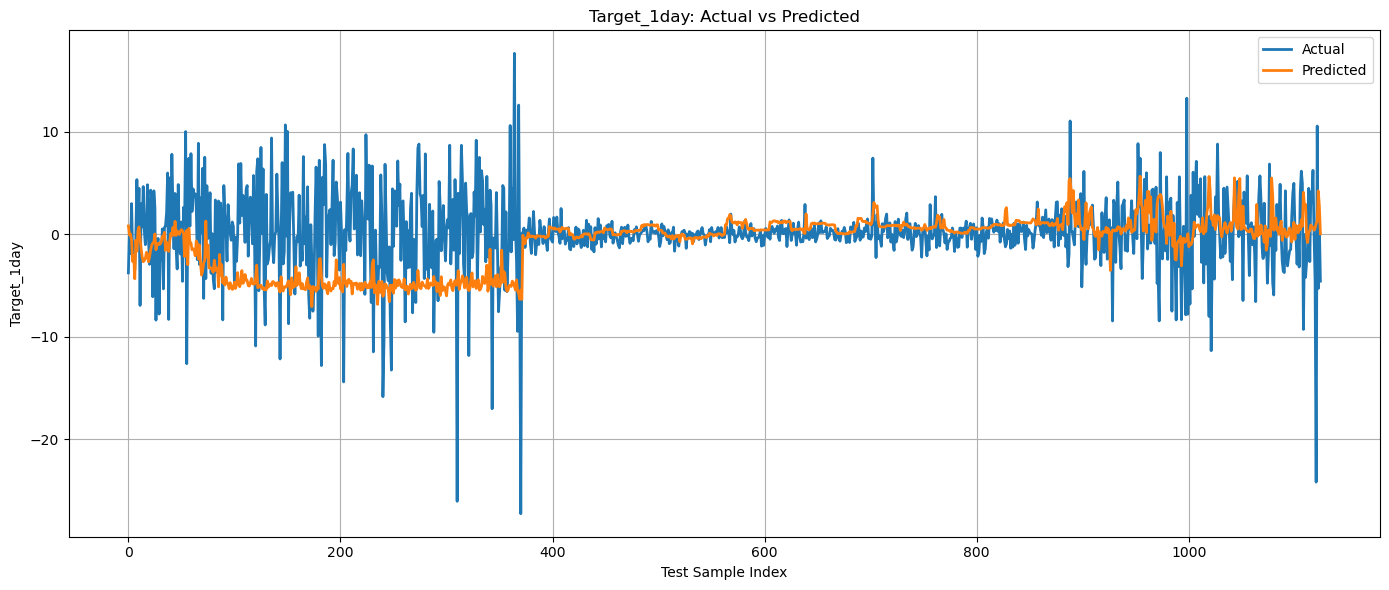

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 20, 'n_estimators': 100}

 Evaluation:
Mean Squared Error (MSE): 49.5392
Mean Absolute Error (MAE): 4.9056
R² Score: 0.1295


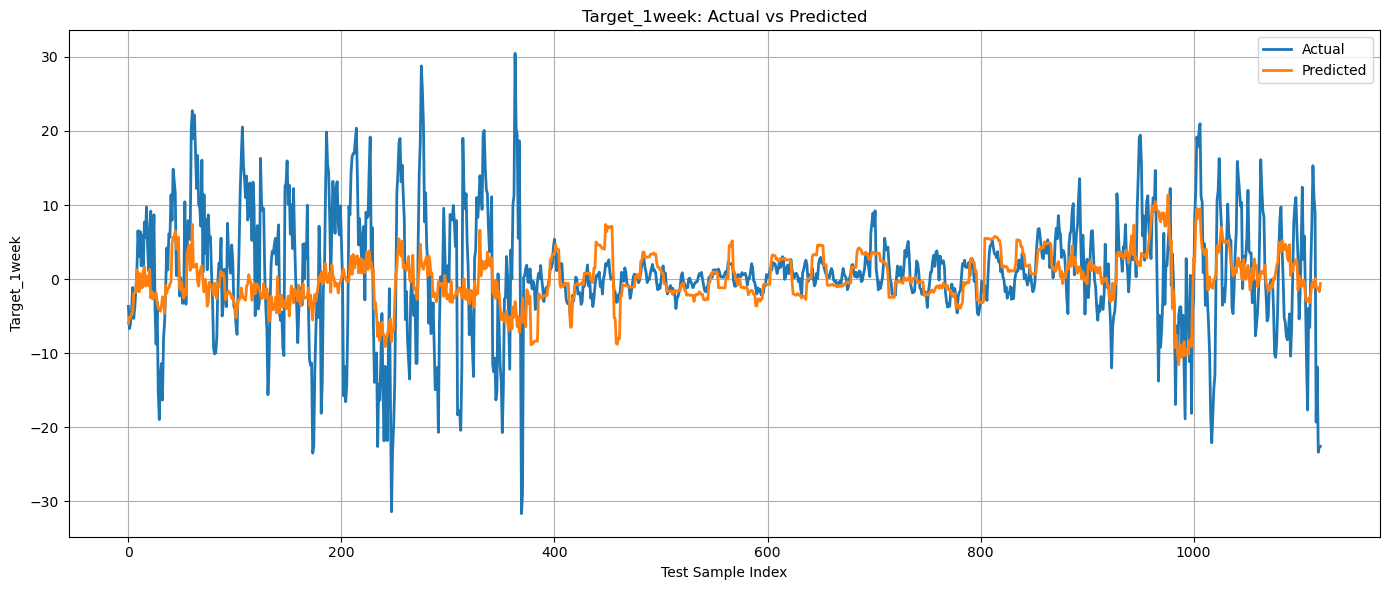

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': None, 'n_estimators': 100}

 Evaluation:
Mean Squared Error (MSE): 178.8037
Mean Absolute Error (MAE): 9.6109
R² Score: 0.0738


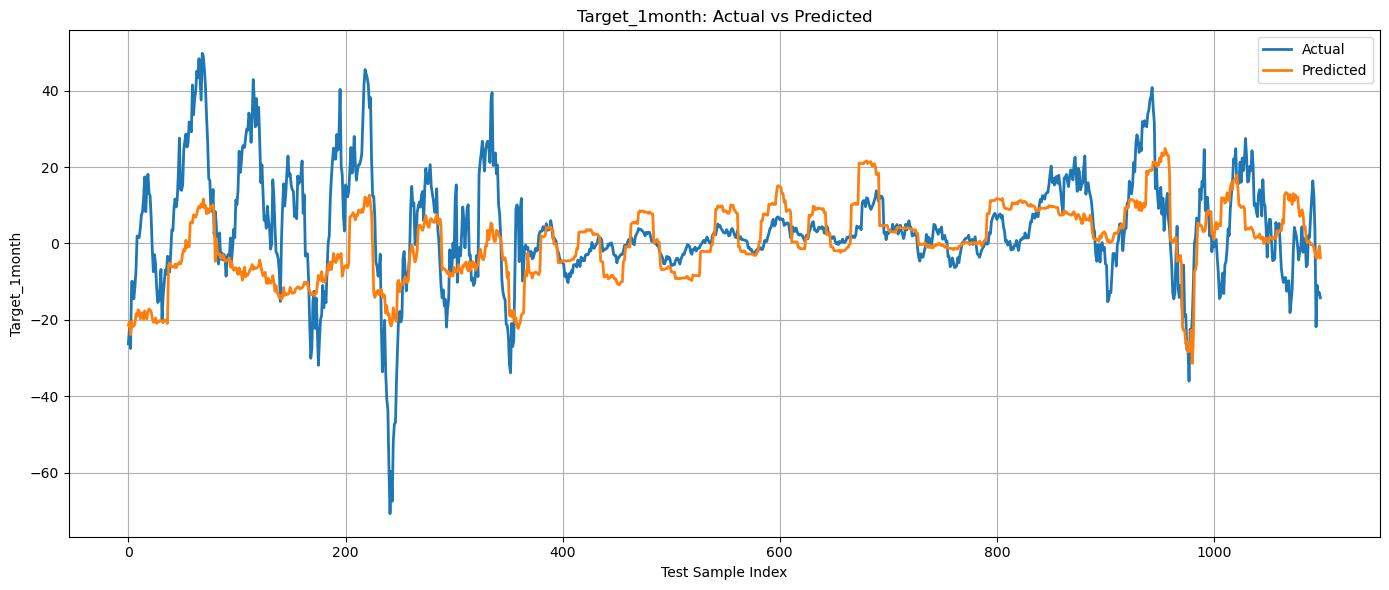

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 20, 'n_estimators': 100}

 Evaluation:
Mean Squared Error (MSE): 559.5471
Mean Absolute Error (MAE): 18.2462
R² Score: 0.6752


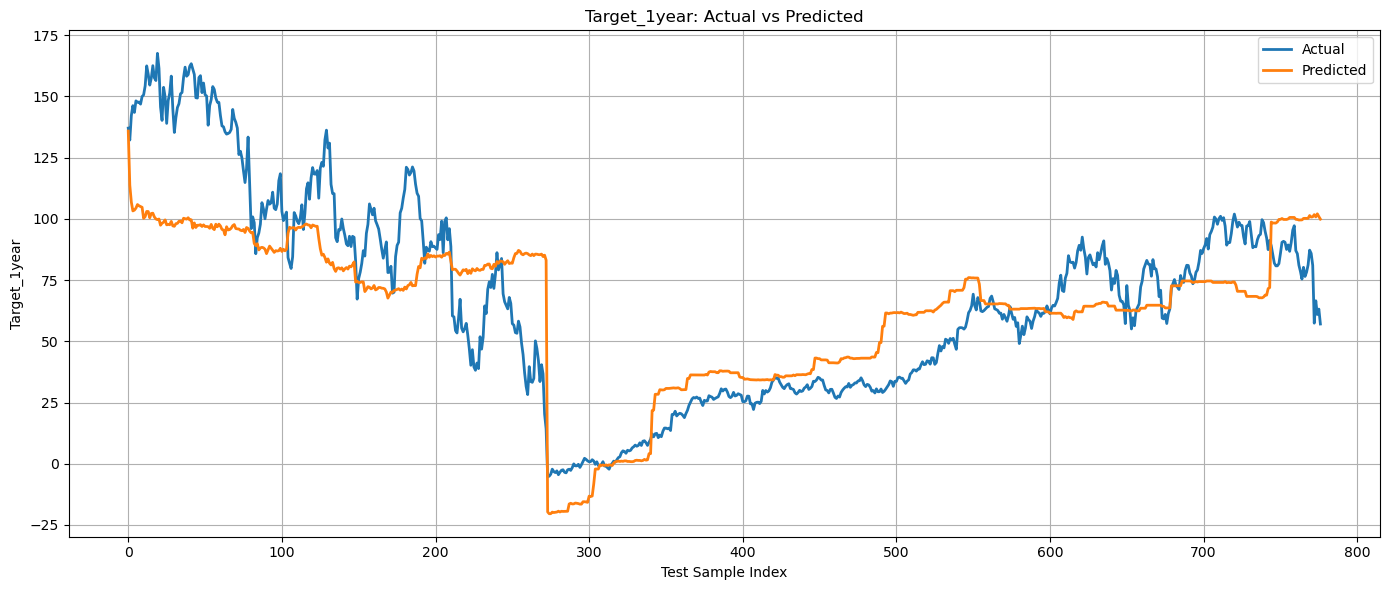

In [ ]:
random_forest(df, 'Target_1day')
random_forest(df, 'Target_1week')
random_forest(df, 'Target_1month')
random_forest(df, 'Target_1year')

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': None, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 21.7606
Mean Absolute Error (MAE): 3.1881
R² Score: -0.6489


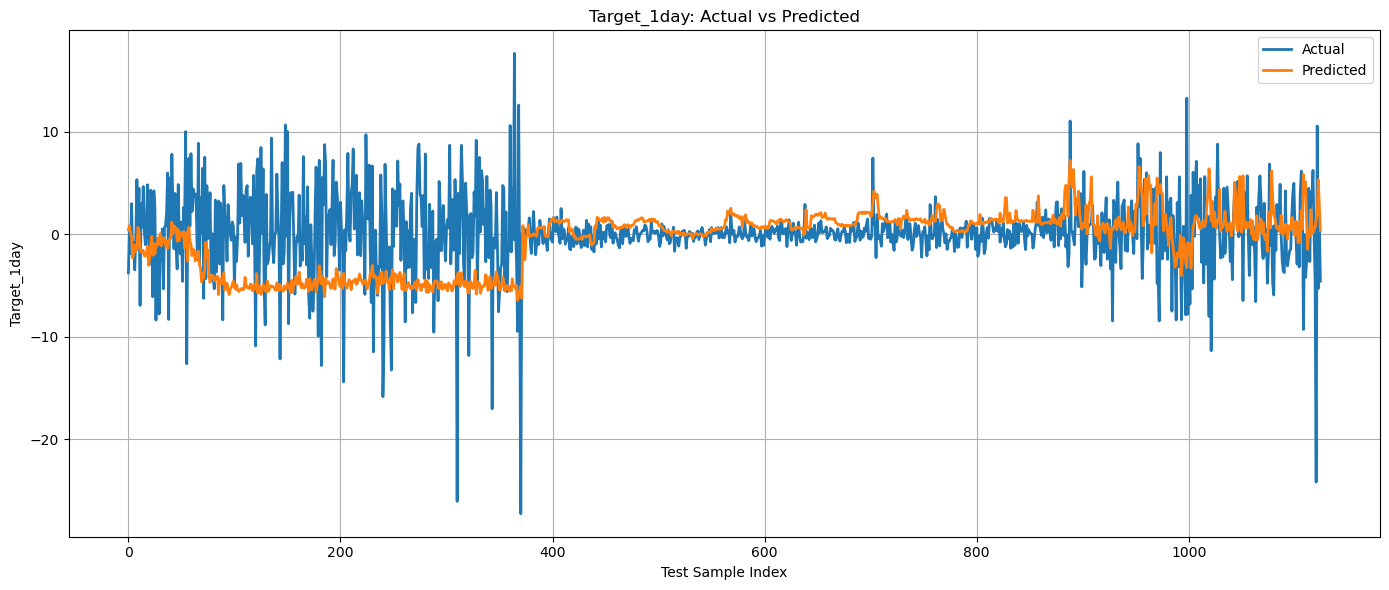

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': None, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 51.7562
Mean Absolute Error (MAE): 5.0480
R² Score: 0.0906


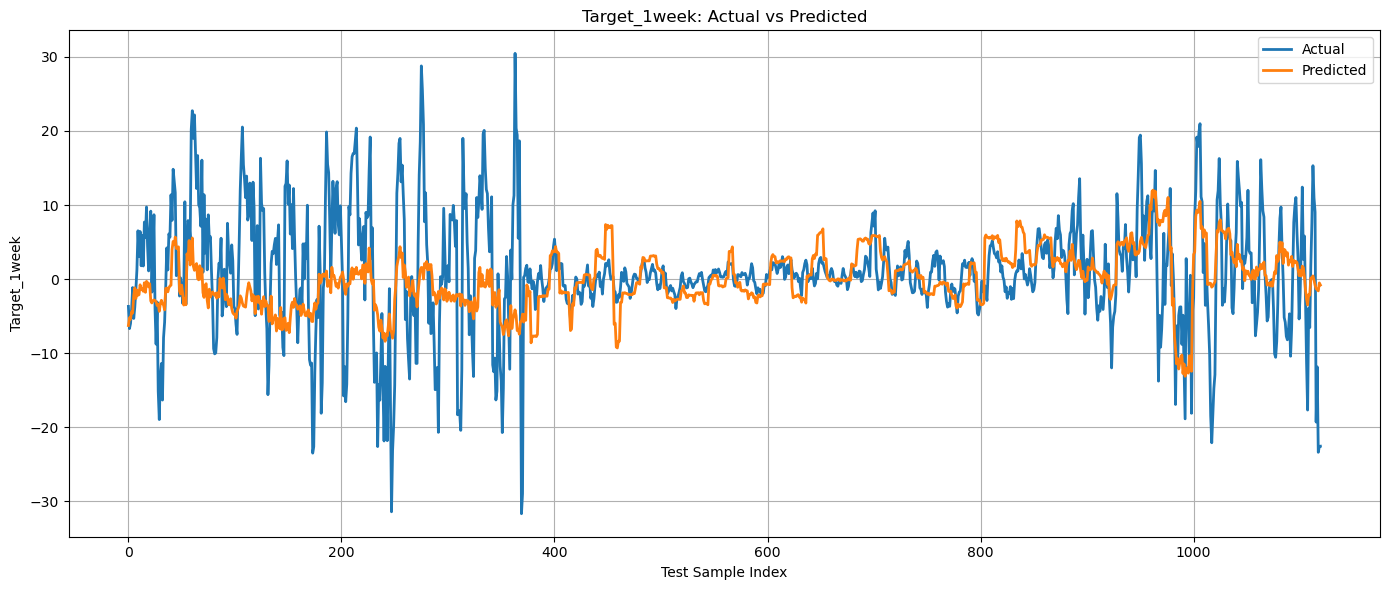

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 10, 'n_estimators': 100}

 Evaluation:
Mean Squared Error (MSE): 174.5307
Mean Absolute Error (MAE): 9.5165
R² Score: 0.0959


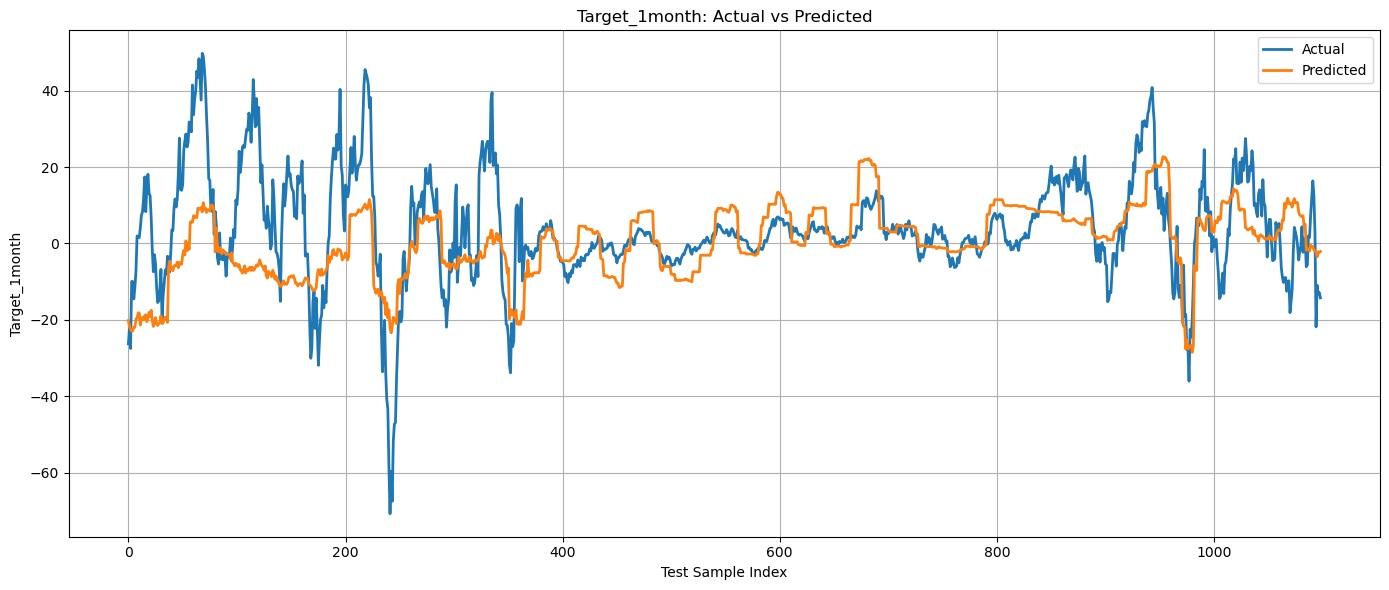

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 20, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 553.8494
Mean Absolute Error (MAE): 18.0359
R² Score: 0.6786


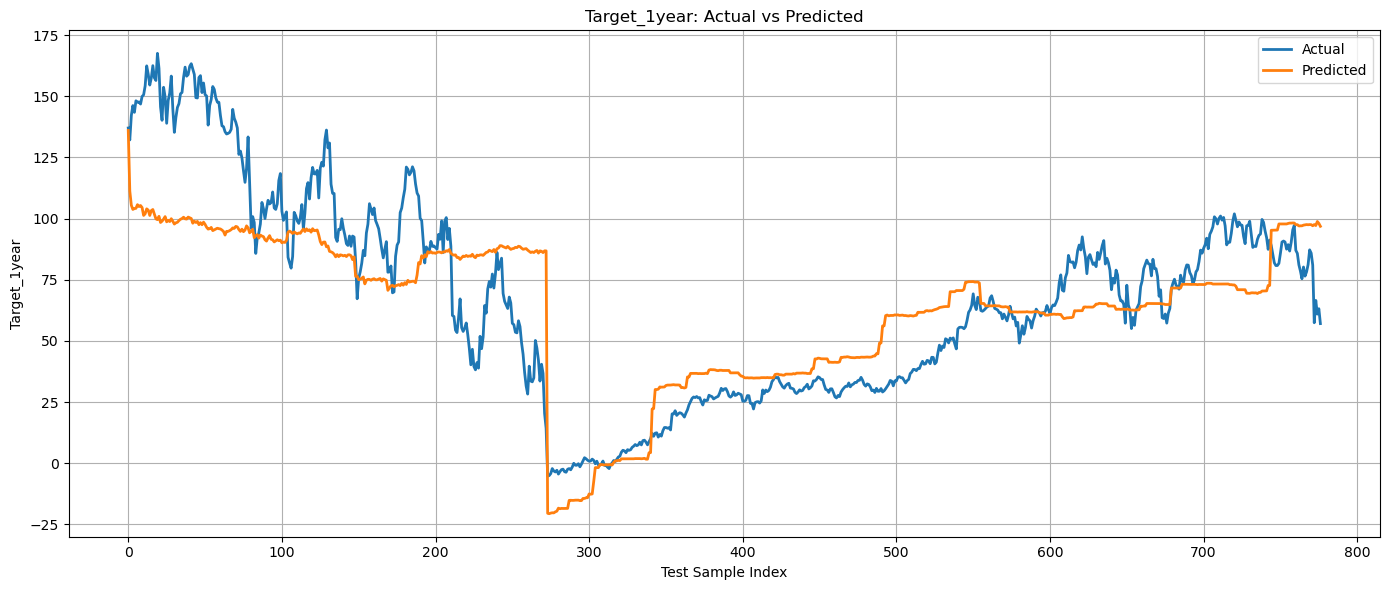

In [ ]:
random_forest(df_pca, 'Target_1day')
random_forest(df_pca, 'Target_1week')
random_forest(df_pca, 'Target_1month')
random_forest(df_pca, 'Target_1year')

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

def lightgbm_model(data, target):
    df = data.copy()

    # Target setting
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    df['Date'] = pd.to_datetime(df['Date'])

    # Ticker encoding
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y
    y = df[target]
    X = df.drop(columns=['Date', target])

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Hyperparameter
    param_grid = {
        'num_leaves': [31, 63],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200]
    }

    # GridSearchCV
    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1)
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               verbose=0,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # Prediction
    y_pred = best_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Visualization
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted (LightGBM)')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Best Parameters:
{'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 63}

 Evaluation:
Mean Squared Error (MSE): 13.3885
Mean Absolute Error (MAE): 2.2833
R² Score: -0.0145


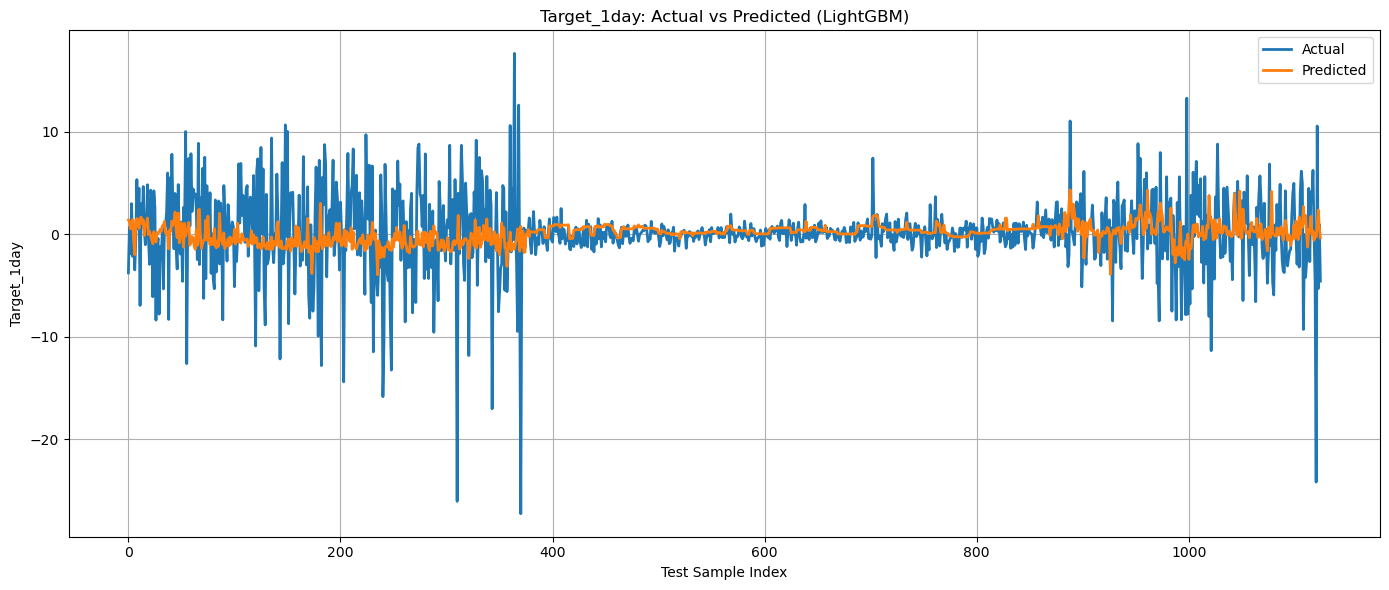

Best Parameters:
{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 63}

 Evaluation:
Mean Squared Error (MSE): 50.1535
Mean Absolute Error (MAE): 4.8281
R² Score: 0.1187


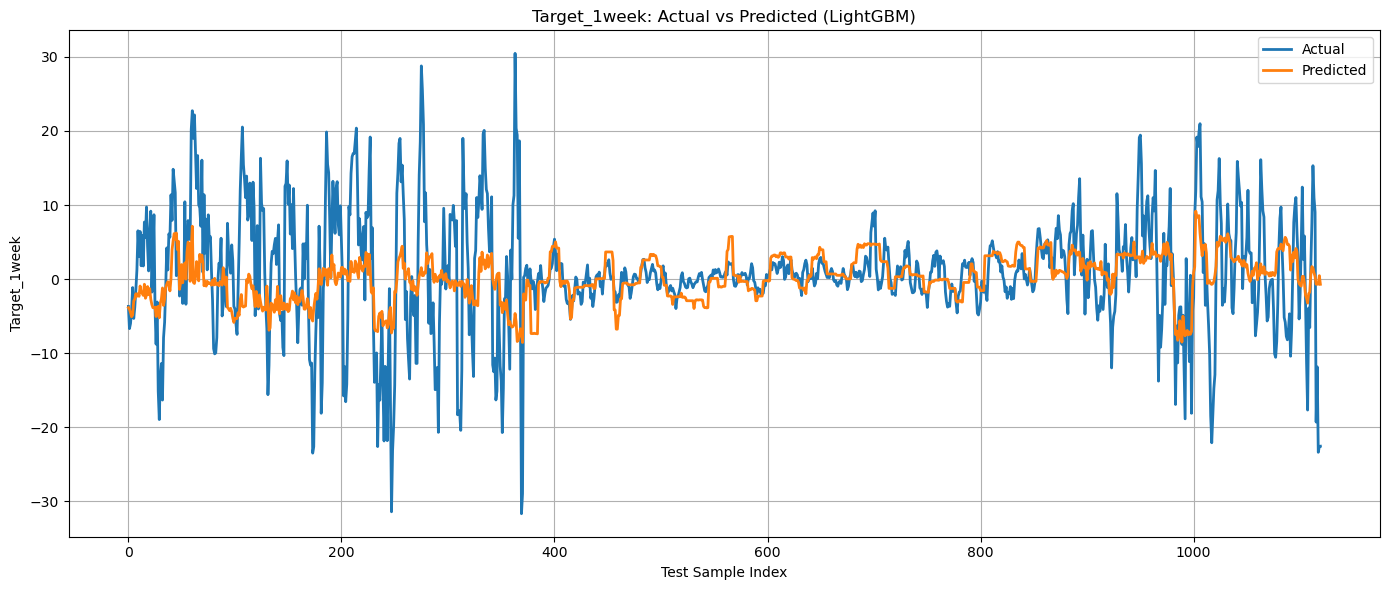

Best Parameters:
{'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 63}

 Evaluation:
Mean Squared Error (MSE): 196.2069
Mean Absolute Error (MAE): 9.3555
R² Score: -0.0164


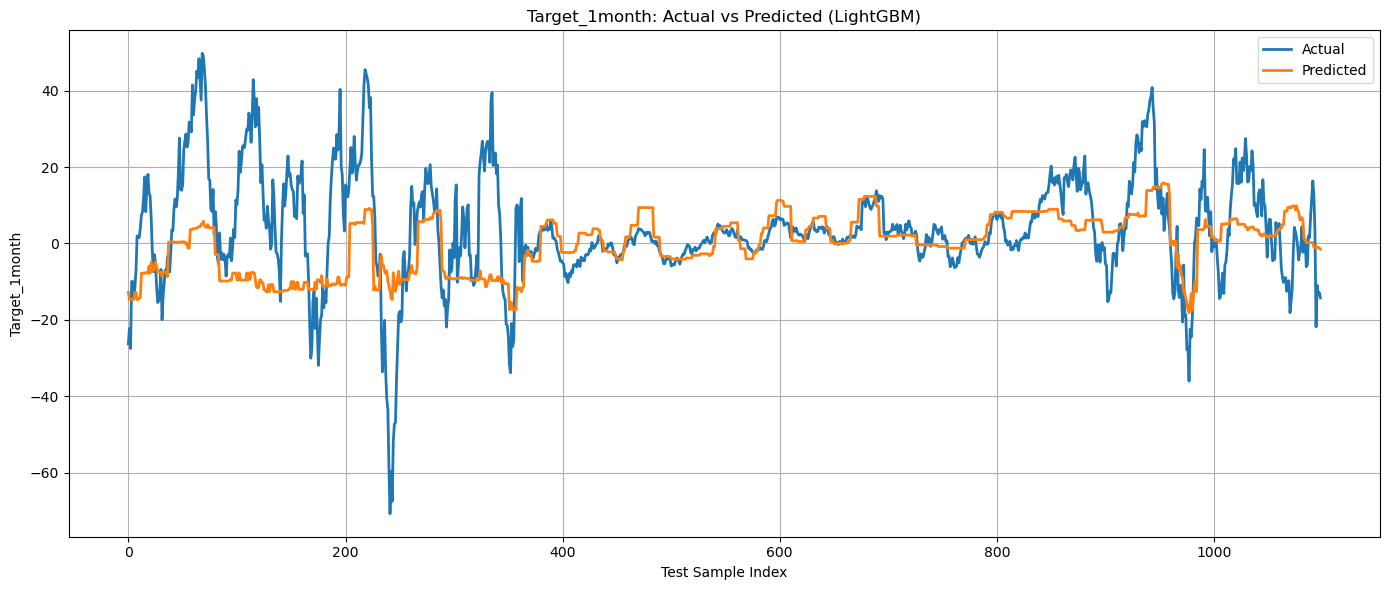

Best Parameters:
{'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 63}

 Evaluation:
Mean Squared Error (MSE): 929.5175
Mean Absolute Error (MAE): 21.9205
R² Score: 0.4605


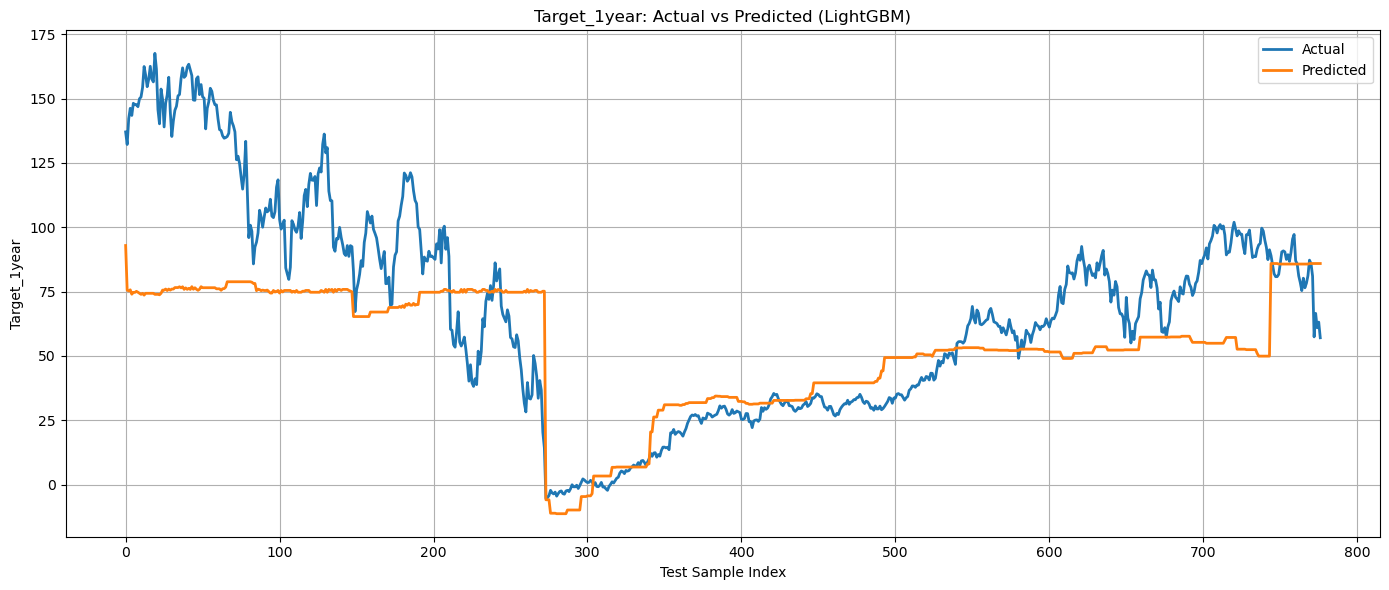

In [ ]:
lightgbm_model(df, 'Target_1day')
lightgbm_model(df, 'Target_1week')
lightgbm_model(df, 'Target_1month')
lightgbm_model(df, 'Target_1year')

Best Parameters:
{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 63}

 Evaluation:
Mean Squared Error (MSE): 13.3131
Mean Absolute Error (MAE): 2.2462
R² Score: -0.0088


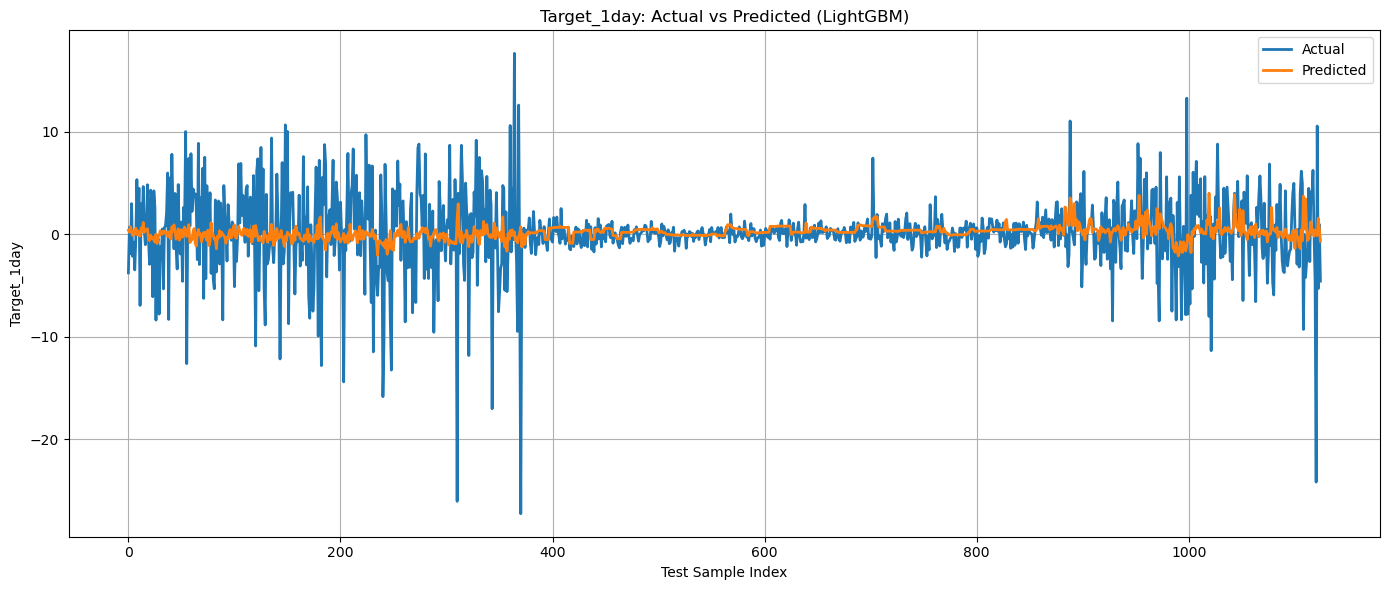

Best Parameters:
{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 63}

 Evaluation:
Mean Squared Error (MSE): 51.1289
Mean Absolute Error (MAE): 4.8909
R² Score: 0.1016


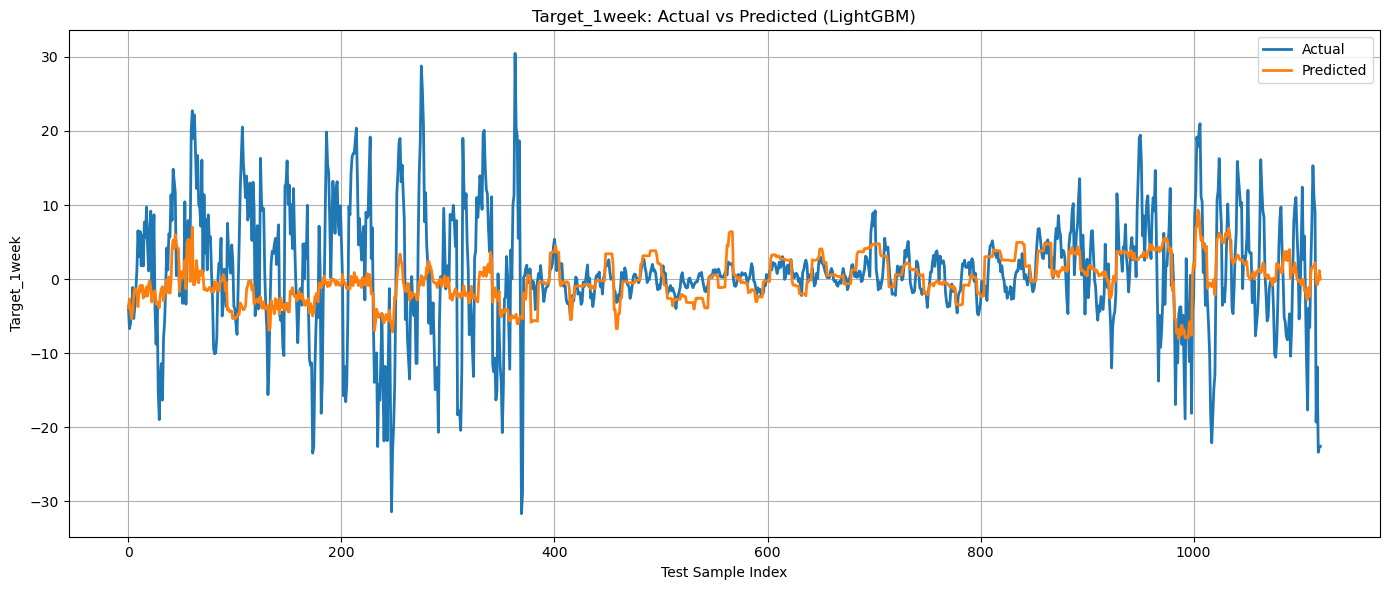

Best Parameters:
{'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31}

 Evaluation:
Mean Squared Error (MSE): 165.5787
Mean Absolute Error (MAE): 8.5985
R² Score: 0.1423


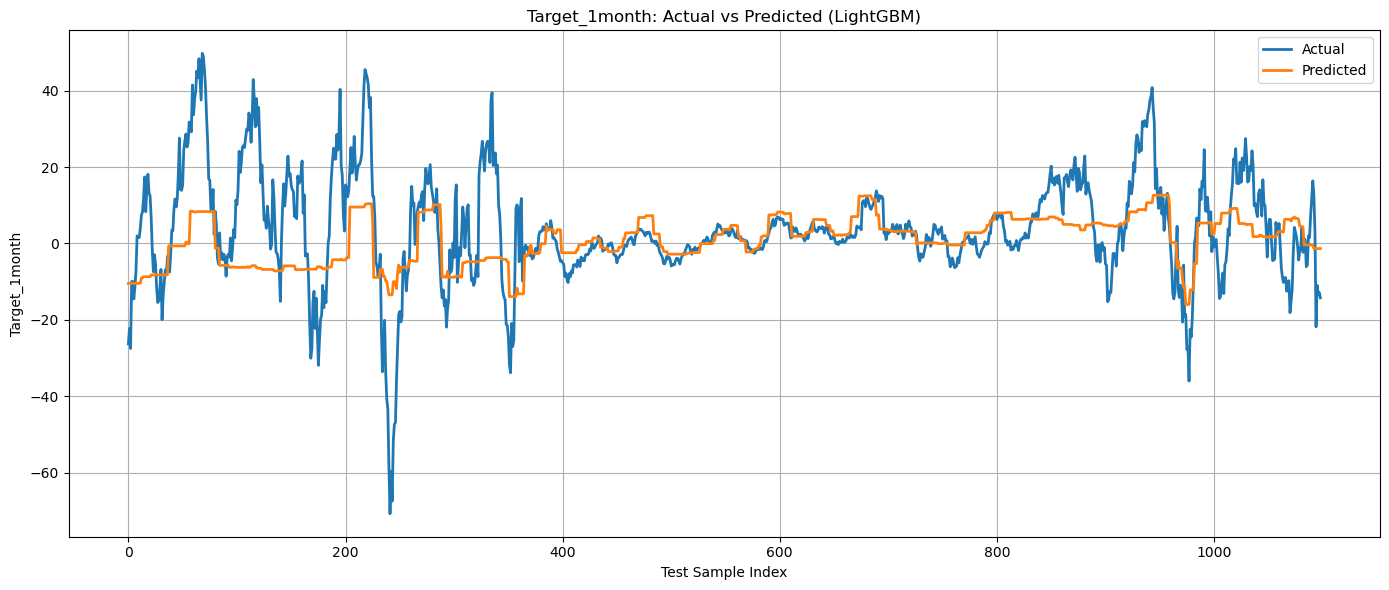

Best Parameters:
{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 63}

 Evaluation:
Mean Squared Error (MSE): 895.0500
Mean Absolute Error (MAE): 21.5385
R² Score: 0.4805


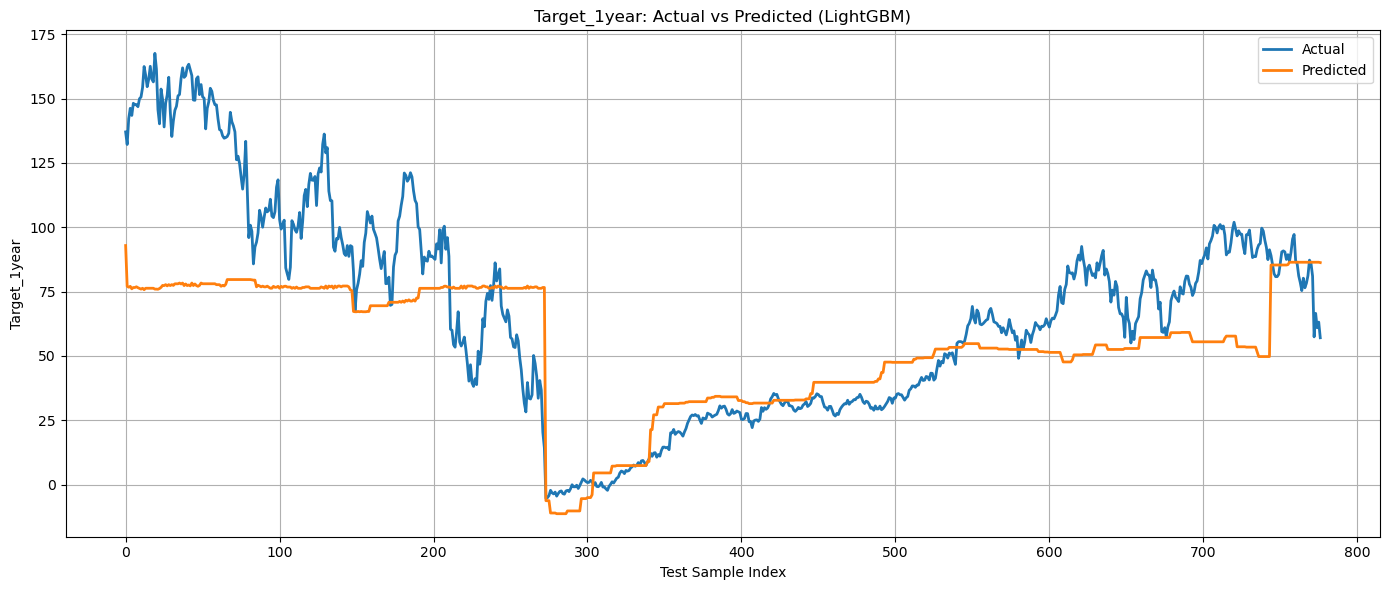

In [ ]:
lightgbm_model(df_pca, 'Target_1day')
lightgbm_model(df_pca, 'Target_1week')
lightgbm_model(df_pca, 'Target_1month')
lightgbm_model(df_pca, 'Target_1year')